## Description

There is a used car buying and selling company that is developing an application to attract new buyers. In this application, you can quickly determine the market value of your car. You have access to historical data, vehicle technical specifications, vehicle model versions, and vehicle prices.

The company is interested in:
- Prediction quality
- Prediction speed
- Time required to train the model

## Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## Pre-processing Data

In [2]:
try:
    df = pd.read_csv('D:/datasets/car_data.csv')
except:
    df = pd.read_csv('/datasets/car_data.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
# Checking Dataset Information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
# Checking The Missing Values
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
# Checking The Duplicate Values
df.duplicated().sum()

262

**Columns to Be Fixed:**
- The `DateCrawled`, `DateCreated`, and `LastSeen` columns have incorrect data types. They should have the Date data type.
- There are many missing values in the `VehicleType`, `GearBox`, `Model`, `FuelType`, and `NotRepaired` columns. These five columns are categorical columns that will be filled with NaN values.

**Columns That Become Features:**
- `VehicleType`
- `RegistrationYear`
- `GearBox`
- `Power`
- `Model`
- `Mileage`
- `RegistrationMonth`
- `FuelType`
- `Brand`
- `NotRepaired`

Since the date, number of pictures, and postal code have no relationship with model development, we will not include them as features.

**Columns That Become the Target:**
- `Target`

**Additional Information:**
This data also contains duplicate values that need to be removed.

In [7]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


**Information Obtained:**
- For the `Price` column, there is a minimum price of 0, which is unreasonable when the price is 0.
- For the `RegistrationYear` column, there is a minimum year of 1000 and a maximum year of 9999, which is unreasonable for years.
- For the `Power` column, there is a minimum value of 0, which is unreasonable.
- For the `RegistrationMonth` column, there is a minimum value of 0, which is unreasonable.

## Improving Dataset

In [8]:
# Change the columns data type
columns = ['DateCrawled', 'DateCreated', 'LastSeen']
for i in columns:
    df[i] = pd.to_datetime(df[i], format='%d/%m/%Y %H:%M')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

In [10]:
# Filling the categorical column with None
categorical = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']
for i in categorical:
    df[i] = df[i].fillna('None')

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        354369 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            354369 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              354369 non-null  object        
 7   Mileage            354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           354369 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        354369 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

## Checking The Outlier

array([[<AxesSubplot:title={'center':'RegistrationYear'}>]], dtype=object)

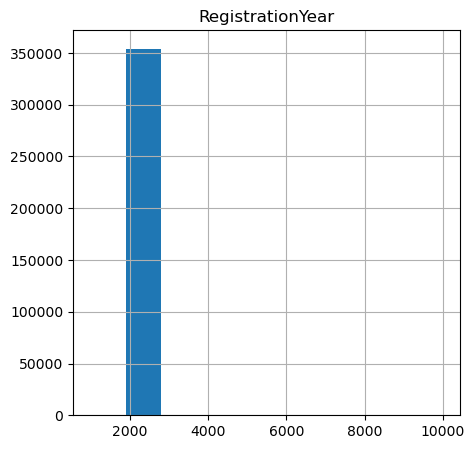

In [12]:
# Checking outlier in RegsitrationYear column
df.hist("RegistrationYear", figsize=(5,5))

array([[<AxesSubplot:title={'center':'Power'}>]], dtype=object)

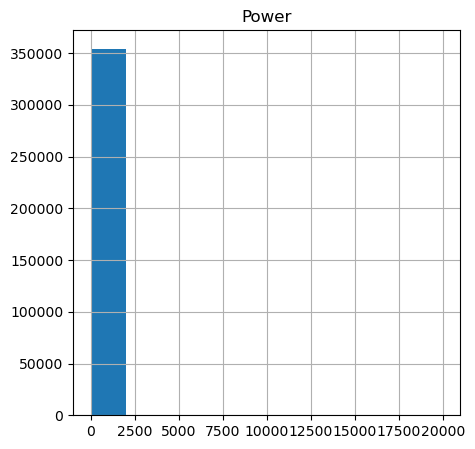

In [13]:
# Checking outlier in Power column
df.hist("Power", figsize=(5,5))

array([[<AxesSubplot:title={'center':'Mileage'}>]], dtype=object)

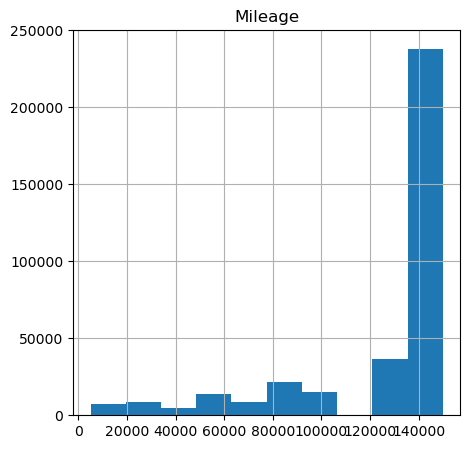

In [14]:
# Checking outlier in Mileage column
df.hist("Mileage", figsize=(5,5))

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

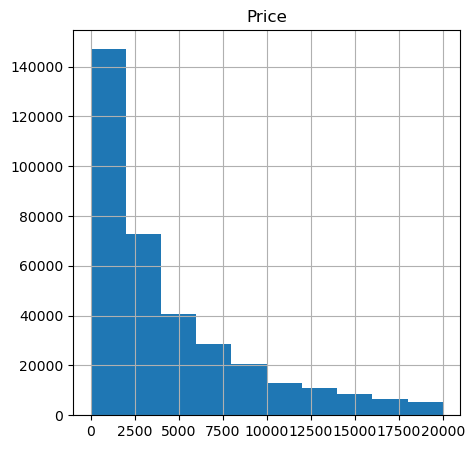

In [15]:
# Checking outlier in Price column
df.hist("Price", figsize=(5,5))

**From the information above, we can conclude:**
- For the `RegistrationYear` column, there are extremely high values, around the 2000s. We may consider taking data within that year range.
- For the `Power` column, there are values ranging from 0 to 250. We may consider taking values between 100 and 1500, as economical cars with small engines may have around 60 to 100 horsepower, while high-performance or racing cars can have hundreds to thousands of horsepower.
- For the `Mileage` column, there is a spike in values around 14,000. However, this is not a significant outlier given that there are many used cars with high mileage.
- For the `Price` column, there are many values around or below 2,500. For this column, we may consider taking values greater than 0 and in whole numbers, as car prices that are too low are highly unlikely.

## Create Boxplot

### Year Column

In [16]:
q1_year = df['RegistrationYear'].quantile(0.25)
q3_year = df['RegistrationYear'].quantile(0.75)
iqr_year = q3_year - q1_year
upper_bound_year = q3_year+(1.5*iqr_year)
lower_bound_year = q1_year-(1.5*iqr_year)

2021.5

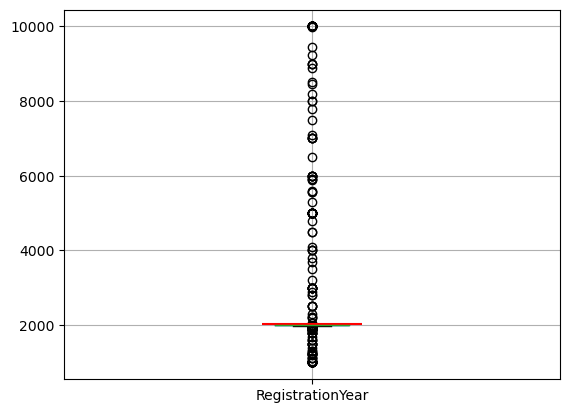

In [17]:
df.boxplot(column='RegistrationYear')
plt.hlines(y=upper_bound_year, xmin=0.9, xmax=1.1, color='red')
upper_bound_year

1985.5

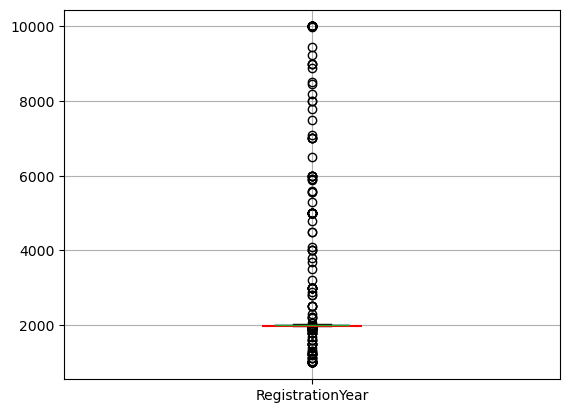

In [18]:
df.boxplot(column='RegistrationYear')
plt.hlines(y=lower_bound_year, xmin=0.9, xmax=1.1, color='red')
lower_bound_year

We will take data from 1986 to 2022. This decision is based on the boxplot we observed, which showed the upper bound as 2021.5 and the lower bound as 1985.5.

### Filtering Data

In [19]:
# filtering data

# Removing the unrealistic price values from the price column
df = df[df['Price'] > 1000]
# Removing unrealistic values from the `Power` column
df=df[(df['Power'] >= 60) & (df['Power'] <= 2000)]
# Removing unrealistic values (0) from the `RegistrationMonth` column
df=df[df['RegistrationMonth']!=0]
# Filtering the dataset to include only the rows with registration years between 1986 and 2022
df=df[(df['RegistrationYear'] >= 1986) & (df['RegistrationYear'] <= 2022)]
# Removing the duplicates values
df.drop_duplicates(inplace=True)

df = df.reset_index(drop=True)

In [20]:
df['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [21]:
df['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000',
       '911', 'None', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espa

In [22]:
df = df.drop(['Brand', 'Model'], axis=1)

In [23]:
df.shape

(222242, 14)

In [24]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Mileage,RegistrationMonth,FuelType,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 10:58:00,18300,coupe,2011,manual,190,125000,5,gasoline,yes,2016-03-24,0,66954,2016-04-07 01:46:00
1,2016-03-14 12:52:00,9800,suv,2004,auto,163,125000,8,gasoline,None,2016-03-14,0,90480,2016-04-05 12:47:00
2,2016-03-17 16:54:00,1500,small,2001,manual,75,150000,6,petrol,no,2016-03-17,0,91074,2016-03-17 17:40:00
3,2016-03-31 17:25:00,3600,small,2008,manual,69,90000,7,gasoline,no,2016-03-31,0,60437,2016-04-06 10:17:00
4,2016-04-01 20:48:00,2200,convertible,2004,manual,109,150000,8,petrol,no,2016-04-01,0,67112,2016-04-05 18:18:00


## Training Model

In [25]:
# Determine features and target.
features = df.drop(['DateCrawled', 'Price', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
target = df['Price']
print(features.shape)
print(target.shape)

(222242, 8)
(222242,)


In [26]:
categorical = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']

# ohe
ohe = pd.get_dummies(data=features, columns=categorical, drop_first=True)

# splitting data set for XGBoost and Linear Regression
features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(ohe, target, test_size=0.25,\
                                                                                            random_state=12345, shuffle=False)

# splitting data set for others model
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25,\
                                                                            random_state=12345, shuffle=False)

In [27]:
numerical = ['RegistrationYear', 'Mileage', 'Power','RegistrationMonth']

# doing standard scaler
scaler = StandardScaler()

scaler.fit(features_train_ohe[numerical])

features_train_ohe[numerical] = scaler.transform(features_train_ohe[numerical])
features_test_ohe[numerical] = scaler.transform(features_test_ohe[numerical])

features_train[numerical] = scaler.transform(features_train[numerical])
features_test[numerical] = scaler.transform(features_test[numerical])

## RMSE Function

In [28]:
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse
scorer = make_scorer(calculate_rmse, greater_is_better=False)

## Linear Regression

In [29]:
# linear regression model
lr = LinearRegression()

In [30]:
# Checking the linear regression training time
%time lr.fit(features_train_ohe, target_train_ohe)

Wall time: 415 ms


LinearRegression()

In [31]:
# Checking the linear regression prediction time
%time lr_predict = lr.predict(features_test_ohe)

Wall time: 23.6 ms


In [32]:
lr_rmse = calculate_rmse(target_test_ohe, lr_predict)
lr_rmse

2860.9315954392473

For the Linear Regression model, it took approximately **415 ms** for training and around **16 ms** for prediction. The RMSE value for this model is approximately **2860.93**. This value will be used as a benchmark when performing a sanity check for other models.

## Decision Tree

In [33]:
# Checking the performance of the Decision Tree model at each depth
for depth in range(1, 10):
    dst = DecisionTreeRegressor(max_depth=depth, random_state=12345)
    dst_score = -cross_val_score(dst, features_train_ohe, target_train_ohe, cv=5, scoring=scorer)
    print("Depth:", depth, "Score:", dst_score.mean())

Depth: 1 Score: 3821.183885206117
Depth: 2 Score: 3370.769676586996
Depth: 3 Score: 3100.8582714425347
Depth: 4 Score: 2802.8083357217874
Depth: 5 Score: 2596.7975554498416
Depth: 6 Score: 2447.037860964498
Depth: 7 Score: 2319.808522261106
Depth: 8 Score: 2235.6846046301166
Depth: 9 Score: 2188.769757420935


At a depth of 9, the lowest value is **2188.76**. Therefore, we will use a hyperparameter of 9 for the depth of the Decision Tree.

**Explanation:** The RMSE result is converted to a negative value with a negative sign in front to ensure that a lower score (closer to zero) is considered better in the context of the evaluation metric.

In [34]:
# Using the Decision Tree with a max_depth of 8 and observing the training time
dst = DecisionTreeRegressor(max_depth=9, random_state=12345)
%time dst.fit(features_train_ohe, target_train_ohe)

Wall time: 909 ms


DecisionTreeRegressor(max_depth=9, random_state=12345)

In [35]:
# Observing the prediction time of the Decision Tree
%time dst_prediction = dst.predict(features_test_ohe)

# The RMSE value for the Decision Tree
dst_RMSE = calculate_rmse(target_test_ohe, dst_prediction)
dst_RMSE

Wall time: 21.1 ms


2171.343877212961

The RMSE value for the DST is lower compared to Linear Regression. The training time is faster, and the prediction time is only a few milliseconds longer than Linear Regression.

## Random Forest Regressor

In [36]:
# Evaluating the performance of Random Forest Regression for prediction
for depth in range(1,10):
    rfr = RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=12345)
    rfr_score = -cross_val_score(rfr, features_train_ohe, target_train_ohe, cv=5, scoring=scorer)
    print("Depth:", depth, "Score:", rfr_score.mean())

Depth: 1 Score: 3821.184379753961
Depth: 2 Score: 3351.262780699674
Depth: 3 Score: 3072.2817010337467
Depth: 4 Score: 2762.7164395205996
Depth: 5 Score: 2549.234619212476
Depth: 6 Score: 2381.7818054975287
Depth: 7 Score: 2258.5807158637886
Depth: 8 Score: 2174.202075993243
Depth: 9 Score: 2113.66288674242


Similar to the Decision Tree, Random Forest achieved its best score at a depth of 9. So, the model will be trained with a depth parameter of 9 and 50 estimators.

**Explanation:** The RMSE result is converted to a negative value with a negative sign in front to ensure that lower scores (closer to zero) are considered better in the context of evaluation metrics.

In [37]:
rfr = RandomForestRegressor(n_estimators=50, max_depth=9, random_state=12345)
%time rfr.fit(features_train_ohe, target_train_ohe)

Wall time: 32.4 s


RandomForestRegressor(max_depth=9, n_estimators=50, random_state=12345)

In [38]:
%time rfr_predict = rfr.predict(features_test_ohe)

Wall time: 444 ms


In [39]:
rfr_RMSE = calculate_rmse(target_test_ohe, rfr_predict)
rfr_RMSE

2106.730314080672

The RMSE value for Random Forest is better than the Linear Regression and Decision Tree Regressor models. However, it takes longer time for both training and prediction processes.

## Cat Boost

In [40]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired']

# Cat Booster model
cbr = CatBoostRegressor()
parameters = {
    'depth':[5, 10],
    'learning_rate':[0.5, 0.1],
    'l2_leaf_reg':[4, 5],
    'iterations':[10, 50],
    'loss_function':['RMSE'],
    'random_seed':[12345]
}

# hyperparameter tuning using GridSearchCV
grid_cv = GridSearchCV(estimator=cbr, param_grid=parameters, scoring=scorer, cv=5, n_jobs=-1, verbose=10)
grid_cv.fit(features_train, target_train, cat_features=cat_features)
best_param=grid_cv.best_params_ 

Fitting 5 folds for each of 16 candidates, totalling 80 fits
0:	learn: 3162.3773068	total: 629ms	remaining: 30.8s
1:	learn: 2583.6907882	total: 1.06s	remaining: 25.4s
2:	learn: 2385.8967202	total: 1.48s	remaining: 23.2s
3:	learn: 2267.0696075	total: 1.92s	remaining: 22s
4:	learn: 2198.5658678	total: 2.3s	remaining: 20.7s
5:	learn: 2167.3417679	total: 2.7s	remaining: 19.8s
6:	learn: 2126.9367478	total: 3.1s	remaining: 19.1s
7:	learn: 2097.5184668	total: 3.59s	remaining: 18.8s
8:	learn: 2078.7024168	total: 3.99s	remaining: 18.2s
9:	learn: 2071.1887624	total: 4.35s	remaining: 17.4s
10:	learn: 2062.0134764	total: 4.75s	remaining: 16.8s
11:	learn: 2048.5588647	total: 5.18s	remaining: 16.4s
12:	learn: 2040.0913383	total: 5.55s	remaining: 15.8s
13:	learn: 2030.9200526	total: 6.02s	remaining: 15.5s
14:	learn: 2024.5254695	total: 6.55s	remaining: 15.3s
15:	learn: 2014.2090424	total: 7.04s	remaining: 15s
16:	learn: 2007.4930693	total: 7.49s	remaining: 14.5s
17:	learn: 2004.8303880	total: 7.75s	r

In [41]:
# Knowing the best values and parameters
print('Best Score:', -grid_cv.best_score_)
print('Parameter:', best_param)

Best Score: 1937.6805326949973
Parameter: {'depth': 10, 'iterations': 50, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'loss_function': 'RMSE', 'random_seed': 12345}


**Explanation:** The RMSE result is converted to a negative value with a negative sign in front (-grid_cv.best_score_) to ensure that lower scores (closer to zero) are considered better in the context of the evaluation metric.

In [42]:
# Knowing the time of catboost training
cbr = CatBoostRegressor(depth=10, iterations=50, l2_leaf_reg=4, learning_rate=0.5, loss_function='RMSE', random_seed=1234)
%time cbr.fit(features_train, target_train, cat_features=cat_features, verbose=False)

Wall time: 14.3 s


In [43]:
# Knowing the time of catboost prediction
%time cbr_predict = cbr.predict(features_test)

Wall time: 438 ms


In [44]:
cbr_RMSE = calculate_rmse(target_test, cbr_predict)
cbr_RMSE

1925.414017089143

The value obtained when using CatBoost is 1670.36, which is better than the baseline model we built earlier.

## LGBM

In [45]:
for i in cat_features:
    features_train[i] = features_train[i].astype('category')

# looking fot the best paramter
lgbm_r = LGBMRegressor()
parameters_lgbm = {
    'objective':['regression_l2'],
    'num_leaves':[10, 50],
    'learning_rate':[0.5, 0.1],
    'n_estimators':[10, 20],
    'random_seed':[12345],
}

# hyperparameter tuning using GridSearchCV
grid_lgbm_r = GridSearchCV(estimator=lgbm_r, param_grid=parameters_lgbm, scoring=scorer, cv=5, n_jobs=-1)
grid_lgbm_r.fit(features_train, target_train)
best_param_lgbm = grid_lgbm_r.best_params_

In [46]:
# Knowing the score and best parameter
print('Best Score:', -grid_lgbm_r.best_score_)
print('Parameter:', best_param_lgbm)

Best Score: 1971.928319437699
Parameter: {'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 50, 'objective': 'regression_l2', 'random_seed': 12345}


**Explanation:** The RMSE result is converted to a negative value with a negative sign in front (-grid_cv.best_score_) to ensure that lower scores (closer to zero) are considered better in the context of the evaluation metric.

In [47]:
# Knowing the time of LGBMRegressor training
lgbm_r = LGBMRegressor(objective='regression_l2', num_leaves=50, learning_rate=0.5, n_estimators=50, random_seed=12345)
%time lgbm_r.fit(features_train, target_train)

Wall time: 2.88 s


LGBMRegressor(learning_rate=0.5, n_estimators=50, num_leaves=50,
              objective='regression_l2', random_seed=12345)

In [48]:
for i in cat_features:
    features_test[i] = features_test[i].astype('category')

# Knowing the time of LGBMRegressor prediction
%time lgbm_predict = lgbm_r.predict(features_test)

Wall time: 188 ms


In [49]:
lgbm_rmse = calculate_rmse(target_test, lgbm_predict)
lgbm_rmse

1908.7937793876004

The values produced by LightGBM are better than CatBoost, and in terms of time, LightGBM is also faster in both training and predicting results.

## XGBoost

Unlike CatBoost and LightGBM, which can predict using categorical data, XGBoost uses one-hot-encoded data for prediction.

In [50]:
xgb_r = XGBRegressor()
parameter_xgb = {
    'max_depth':[3, 5, 7],
    'learning_rate':[0.5, 0.1],
    'n_estimators':[10, 20],
    'eval_metric':['rmse'],
    'seed':[12345]
}

# hyperparamater tuning using GridSearchCV
grid_xgb = GridSearchCV(estimator=xgb_r, param_grid=parameter_xgb, scoring=scorer, cv=5, n_jobs=-1)
grid_xgb.fit(features_train_ohe, target_train_ohe)
best_param_xgb = grid_xgb.best_params_

In [51]:
# knowoing the score and best parameter
print('Best Score:', -grid_xgb.best_score_)
print('Parameter:', best_param_xgb)

Best Score: 1959.4426051419632
Parameter: {'eval_metric': 'rmse', 'learning_rate': 0.5, 'max_depth': 7, 'n_estimators': 20, 'seed': 12345}


**Explanation:** The RMSE result is converted to a negative value with a negative sign in front (-grid_cv.best_score_) to ensure that lower scores (closer to zero) are considered better in the context of the evaluation metric.

In [52]:
# Knowing the time of XGBoostRegressor training
xgb_r = XGBRegressor(max_depth=7, learning_rate=0.5, n_estimators=20, eval_metric='rmse', seed=12345)
%time xgb_r.fit(features_train_ohe, target_train_ohe)

Wall time: 8.28 s


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.5, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [53]:
# Knowing the time of XGBootRegressor prediction
%time xgb_r_predict = xgb_r.predict(features_test_ohe)

Wall time: 45 ms


In [54]:
# calculate the RMSE
xgb_RMSE = calculate_rmse(target_test_ohe, xgb_r_predict)
xgb_RMSE

1951.8224653438072

The XGBoostRegressor model yields a higher score than the LGBM and CatBoost models. However, it takes more time during the training phase.

## Model Analysis

In [55]:
# create the datafram of each model's result
data = {
    'training_time(s)':[0.415, 0.967, 33.5, 6.47, 0.326, 2.49],
    'predict_time(s)':[0.016, 0.0321, 0.431, 0.13, 0.0756, 0.051],
    'RMSE':[2860.93, 2171.43, 2106.73, 1925.41, 1908.79, 1951.82]
}
index = ['LR', 'DTR', 'RFR', 'CatBoost', 'LGBM', 'XGBoost']
model_analysis = pd.DataFrame(data=data, index=index)
model_analysis

,training_time(s),predict_time(s),RMSE
LR,0.415,0.0160,2860.93
DTR,0.967,0.0321,2171.43
RFR,33.500,0.4310,2106.73
CatBoost,6.470,0.1300,1925.41
LGBM,0.326,0.0756,1908.79
XGBoost,2.490,0.0510,1951.82


<AxesSubplot:>

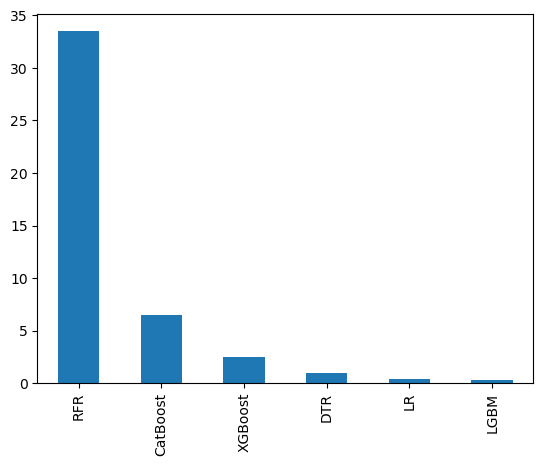

In [56]:
model_analysis['training_time(s)'].sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

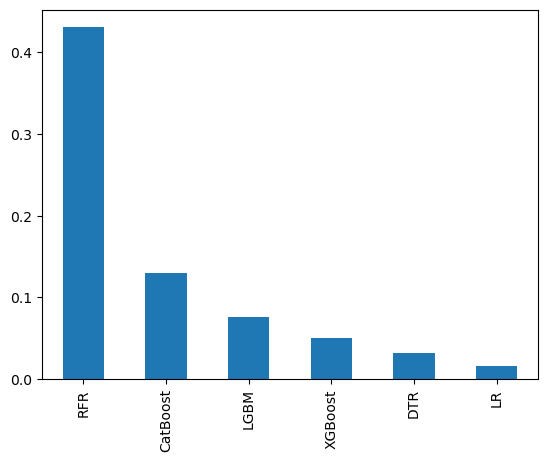

In [57]:
model_analysis['predict_time(s)'].sort_values(ascending=False).plot(kind='bar')

<AxesSubplot:>

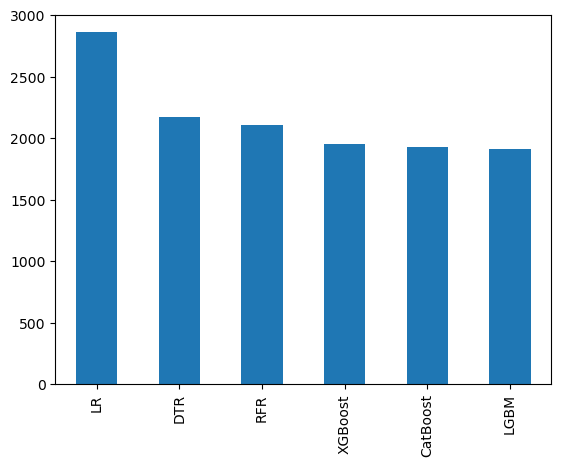

In [58]:
model_analysis['RMSE'].sort_values(ascending=False).plot(kind='bar')

**Information Obtained:**
- For training time, LGBM has the best training time, which is 326 ms. On the other hand, the Random Forest Regressor model has the worst training time, with 33.5 s.
- For prediction time, LGBM has the best prediction time, which is 75.6 ms. On the other hand, the Random Forest Regressor model has the worst prediction time, with 431 ms.
- For RMSE values, LGBM has the lowest RMSE value, which is 1908.79. This value is very close to CatBoost, which is 1925.41. However, in terms of model effectiveness, LGBM is more preferable.

# Conclusion

Based on the results obtained using various models, we can conclude that the model with the best performance is LightGBM. It has lower training time, prediction time, and RMSE values compared to other models and gradient descent methods.

Linear Regression has relatively lower performance, but it can be helpful for conducting Sanity Checks.